In [77]:
with open("input.txt") as file:
    valve_information = file.read().split("\n")

In [66]:
valve_information = """Valve AA has flow rate=0; tunnels lead to valves DD, II, BB
Valve BB has flow rate=13; tunnels lead to valves CC, AA
Valve CC has flow rate=2; tunnels lead to valves DD, BB
Valve DD has flow rate=20; tunnels lead to valves CC, AA, EE
Valve EE has flow rate=3; tunnels lead to valves FF, DD
Valve FF has flow rate=0; tunnels lead to valves EE, GG
Valve GG has flow rate=0; tunnels lead to valves FF, HH
Valve HH has flow rate=22; tunnel leads to valve GG
Valve II has flow rate=0; tunnels lead to valves AA, JJ
Valve JJ has flow rate=21; tunnel leads to valve II""".split("\n")

In [78]:
import parse

In [79]:
def parse_valves(valve_information):
    information = parse.parse("Valve {} has flow rate={}; tunnels lead to valves {}", valve_information)
    if information is None:
        information = parse.parse("Valve {} has flow rate={}; tunnel leads to valve {}", valve_information)
    tunnels = [tunnel.strip() for tunnel in information[2].split(",")]
    return {information[0]:{"flow_rate": int(information[1]), "tunnels":tunnels}}

In [81]:
all_valves = {}
for valve in valve_information:
    all_valves |= parse_valves(valve)

In [84]:
valve_i = 0
for valve in all_valves:
    flow_rate = all_valves[valve]["flow_rate"]
    if flow_rate > 0:
        valve_i += 1
valve_i

15

In [70]:
def calculate_pressure_loss(valves):
    pressure_per_minute = 0
    total_presure_loss = 0
    current_valve = "AA"
    for i in range(30):
        total_presure_loss += pressure_per_minute
        if valves[current_valve]["flow_rate"] > 0:
            pressure_per_minute += valves[current_valve]["flow_rate"]
        else:
            possible_flow_rates = []
            for actions in valves[current_valve]["tunnels"]:
                possible_flow_rates.append(valves[actions]["flow_rate"])
            current_valve = valves[current_valve]["tunnels"][possible_flow_rates.index(max(possible_flow_rates))]
    return total_presure_loss

In [71]:
calculate_pressure_loss(all_valves)

8120

In [72]:
import networkx as nx

In [73]:
G = nx.Graph()

In [74]:
for node in all_valves:
    G.add_node(
        node,
        current_flowrate=0,
        opened=0,
        max_flowrate=all_valves[node]["flow_rate"],
        time_taken=1,
    )


In [75]:
for node in all_valves:
    for end_node in all_valves[node]["tunnels"]:
        G.add_edge(node, end_node, time_taken=1)

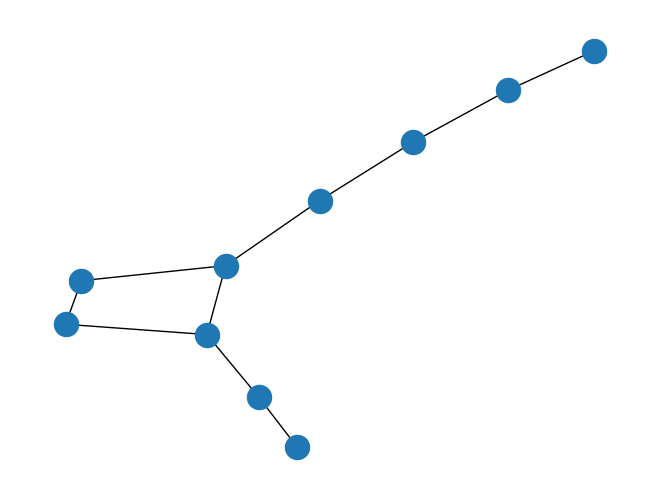

In [76]:
nx.draw(G)